# GCNAE: training animations

## Imports and setup

In [1]:
import time
import random
import os
from collections import defaultdict

import numpy as np
import scipy as sp
import scipy.stats
from scipy import linalg
import sklearn.preprocessing
import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
import seaborn as sb
import networkx as nx

import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback as TQDMCallback

from progressbar import ProgressBar
from IPython.display import SVG, HTML, display

from nw2vec import ae
from nw2vec import utils
from nw2vec import codecs
from nw2vec import layers
from nw2vec import viz
from nw2vec import batching

Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
MODEL_NAME = 'vae-explore'

In [3]:
random.seed(1)
np.random.seed(1)

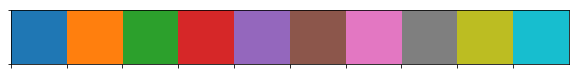

In [4]:
sb.palplot(sb.color_palette())
blue, orange, green, red, purple = sb.color_palette(n_colors=5)

### Model drawing routines

In [5]:
def plot_ξ_distribution(glk, q_model, q_codecs, adj, features, with_kdes=True, fig=None):
    g, l, k = glk
    n_axes = 3 if with_kdes else 2
    palette = np.concatenate([np.array(sb.color_palette(n_colors=l)),
                              .5 * np.ones((l, 1))],
                             axis=1)
    communities = ([[i] for i in range(l)] * np.ones((l, k), dtype=np.int32)).reshape(-1)
    
    if fig is None:
        fig, axes = plt.subplots(1, n_axes, figsize=(4 * n_axes, 4),
                                 subplot_kw=dict(aspect='equal'))#, sharex=True, sharey=True)
    else:
        axes = fig.axes
        assert len(axes) >= 3 if with_kdes else 2

    x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                        adj.shape[0], 1,
                                        p=1, q=1, neighbour_samples=None))
    q_pred = q_model.predict_on_fed_batch(x, feeds=feeds)

    # μ plots
    q_pred_μ = q_pred[:, :2]
    max_mu = np.abs(q_pred_μ).max()
    c_radius = max_mu / (20 - 4)
    circles = [Circle(xy, c_radius, color=palette[communities[i]]) for i, xy in enumerate(q_pred_μ)]
    texts = []
    for i, (x, y) in enumerate(q_pred_μ):
        axes[0].add_artist(circles[i])
        texts.append(axes[0].text(x, y, str(i), ha='center', va='center', color='white'))
    axes[0].set_title(r'$\mu = \left<\xi\right>$ for each node')
    axes[0].set_xlim(- (max_mu + 2 * c_radius), max_mu + 2 * c_radius)
    axes[0].set_ylim(- (max_mu + 2 * c_radius), max_mu + 2 * c_radius)

    # Ellipse plots
    assert len(q_codecs) == 1
    embedding_codec = codecs.available_codecs()[q_codecs[0]](q_pred)
    R = K.eval(embedding_codec.R)
    C = R @ R.transpose([0, 2, 1])

    evals, evecs = zip(*[linalg.eigh(c) for c in C])
    evals = np.array(evals)
    evecs = np.array(evecs)

    e_widths = 3 * 2 * np.sqrt(evals[:, 0])
    e_heights = 3 * 2 * np.sqrt(evals[:, 1])
    e_angles = 180 * np.arctan(evecs[:, 0, 1] / evecs[:, 0, 0]) / np.pi
    ellipses = [Ellipse(q_pred[i, :2], e_widths[i], e_heights[i], e_angles[i],
                        color=palette[communities[i]], alpha=.1)
                for i in range(n_nodes)]
    for ellipse in ellipses:
        axes[1].add_artist(ellipse)
    axes[1].set_title(r'$3 \sigma$ ellipse for each node')
    max_ellipse_radius = max(e_widths.max(), e_heights.max()) / 2
    xylim_sigma = max_ellipse_radius + max_mu
    axes[1].set_xlim(-xylim_sigma, xylim_sigma)
    axes[1].set_ylim(-xylim_sigma, xylim_sigma)
    
    # KDE plots
    if with_kdes:
        q_pred_ξ_sample = K.eval(codecs.available_codecs()[q_codecs[0]](q_pred).stochastic_value(100))
        for i in range(l):
            x = q_pred_ξ_sample[i * k:(i + 1) * k, :, 0].flatten()
            y = q_pred_ξ_sample[i * k:(i + 1) * k, :, 1].flatten()
            sb.kdeplot(x, y, cmap=sb.light_palette(palette[i], as_cmap=True),
                       shade=True, shade_lowest=False, ax=axes[2])
        axes[2].set_title(r'$\xi$ density for each community (flat nodes+sampling)')
        
    # Box representing the μ plots in the KDE and Ellipse plots
    lines = []
    lines.append(axes[1].hlines(axes[0].get_ylim(), *axes[0].get_xlim(), colors='lightgrey'))
    lines.append(axes[1].vlines(axes[0].get_xlim(), *axes[0].get_ylim(), colors='lightgrey'))
    if with_kdes:
        lines.append(axes[2].hlines(axes[0].get_ylim(), *axes[0].get_xlim(), colors='lightgrey'))
        lines.append(axes[2].vlines(axes[0].get_xlim(), *axes[0].get_ylim(), colors='lightgrey'))
    
    fig.tight_layout()
    return fig, (circles, texts, ellipses, lines)

## Test graphs

In [6]:
# Parameters
l = 5
k = 10
p_in = .4
p_out = .01
g = nx.planted_partition_graph(l, k, p_in, p_out)

# Show the graph
labels = np.zeros((l * k, l), dtype=np.float32)
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1

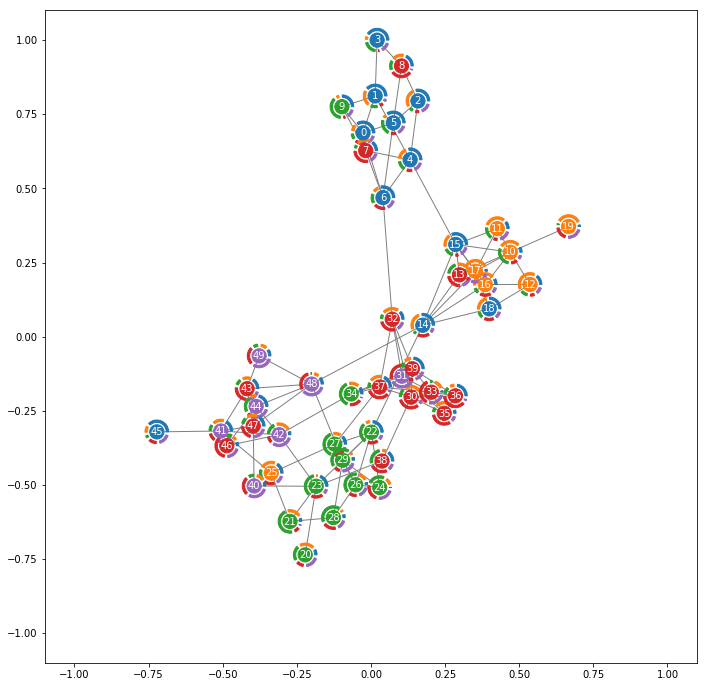

In [7]:
features = labels + np.abs(np.random.normal(loc=0.0, scale=1.2, size=(l * k, l))).astype(np.float32)
viz.draw_network(g, labels=features);

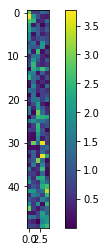

In [8]:
plt.imshow(features)
plt.colorbar()

## Build the VAE

In [9]:
# VAE Parameters
n_nodes = l * k
adj = nx.adjacency_matrix(g).astype(np.float32)

n_ξ_samples = 5
dim_data, dim_l1, dim_ξ = l, 10, 2
dims = (dim_data, dim_l1, dim_ξ)
use_bias = False


# Actual VAE
def build_q(dims, use_bias=False):
    dim_data, dim_l1, dim_ξ = dims

    q_input = keras.layers.Input(shape=(dim_data,), name='q_input')
    # CANDO: change activation
    q_layer1_placeholders, q_layer1 = ae.gc_layer_with_placeholders(
        dim_l1, 'q_layer1', {'use_bias': use_bias, 'activation': 'relu'}, q_input)
    q_μ_flat_placeholders, q_μ_flat = ae.gc_layer_with_placeholders(
        dim_ξ, 'q_mu_flat', {'use_bias': use_bias, 'gather_mask': True}, q_layer1)
    q_logD_flat_placeholders, q_logD_flat = ae.gc_layer_with_placeholders(
        dim_ξ, 'q_logD_flat', {'use_bias': use_bias, 'gather_mask': True}, q_layer1)
    q_μlogD_flat = keras.layers.Concatenate(name='q_mulogD_flat')(
        [q_μ_flat, q_logD_flat])
    q_model = ae.Model(inputs=([q_input]
                               + q_layer1_placeholders
                               + q_μ_flat_placeholders
                               + q_logD_flat_placeholders),
                       outputs=q_μlogD_flat)

    return q_model, ('OrthogonalGaussian',)

q_model, q_codecs = build_q(dims, use_bias=use_bias)

def p_builder(p_input):
    # CANDO: change activation
    p_layer1 = keras.layers.Dense(dim_l1, use_bias=use_bias, activation='relu',
                                  kernel_regularizer='l2', bias_regularizer='l2',
                                  name='p_layer1')(p_input)
    p_adj = layers.Bilinear(0, use_bias=use_bias,
                            kernel_regularizer='l2', bias_regularizer='l2',
                            name='p_adj')([p_layer1, p_layer1])
    p_v = keras.layers.Dense(dim_data, use_bias=use_bias,
                             kernel_regularizer='l2', bias_regularizer='l2',
                             name='p_v')(p_layer1)
    return ([p_adj, p_v], ('SigmoidBernoulliScaledAdjacency', 'SigmoidBernoulli'))

vae, vae_codecs = ae.build_vae(
    (q_model, q_codecs),
    p_builder,
    n_ξ_samples,
    [
        1.0,  # q loss
        1.0,  # p adj loss
        1.0,  # p v loss
    ],
)

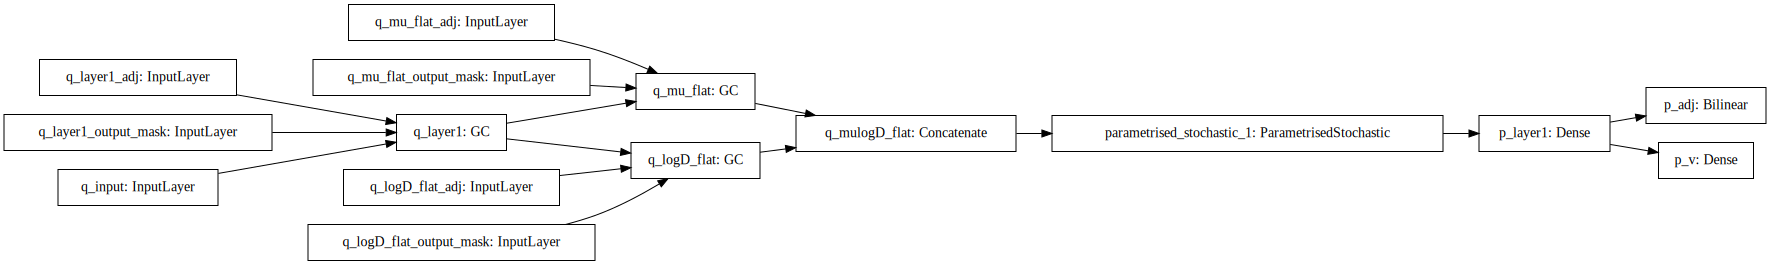

In [10]:
display(SVG(model_to_dot(vae, rankdir='LR').create(prog='dot', format='svg')))

## Target function

In [11]:
def target_func(batch_adj, required_nodes, final_nodes):
    return [
        np.zeros(1), # ignored
        utils.expand_dims_tile(utils.expand_dims_tile(batch_adj + np.eye(batch_adj.shape[0]), 0, n_ξ_samples), 0, 1),
        utils.expand_dims_tile(labels[final_nodes], 1, n_ξ_samples),
    ]

## Before training

$\xi$ averages and distributions for each community, real and predicted adjacency matrices

/home/sl/.conda/envs/base36/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide


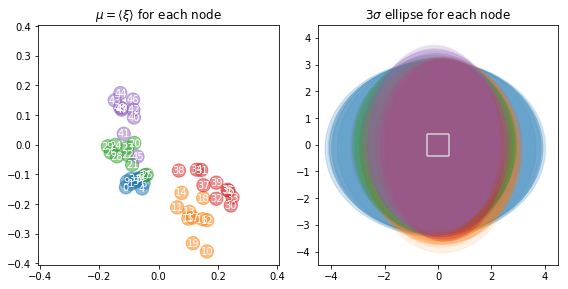

In [12]:
plot_ξ_distribution((g, l, k), q_model, q_codecs, adj, features, with_kdes=False);

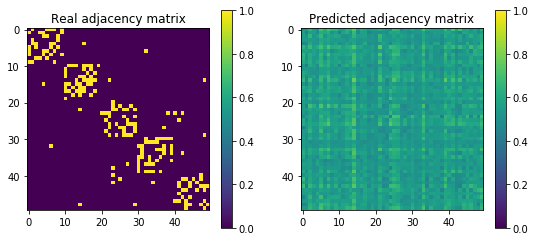

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0]).mean(axis=0))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

## Animate

In [14]:
n_epochs = 5000
seeds_per_batch = n_nodes
max_walk_length = 1
p = 1
q = 1
neighbour_samples = None

steps_per_epoch = int(np.ceil(len(features) / seeds_per_batch))

In [15]:
def build_train_animation():
    ## Plot the first frame
    fig, axes = plt.subplots(2, 4, figsize=(4 * 4, 4 * 2))
    axes[0, -1].set_visible(False)
    _, (mu_circles, mu_texts, sigma_ellipses, box_lines) = plot_ξ_distribution((g, l, k),
                                                                               q_model, q_codecs, adj,
                                                                               features, with_kdes=False, fig=fig)
    x, targets, feeds = next(batching.batches(vae, adj, features, target_func,
                             adj.shape[0], 1,
                             p=1, q=1, neighbour_samples=None))
    q_pred, adj_pred, v_pred = vae.predict_on_fed_batch(x, feeds=feeds)
    adj_im = axes[0, 2].imshow(scipy.special.expit(adj_pred[0]).mean(axis=0))
    axes[0, 2].set_title('Predicted adjacency')
    axes[1, 0].set_title('total loss')
    axes[1, 0].set_xlim(0, n_epochs)
    axes[1, 1].set_title('q_mulogD_flat_loss')
    axes[1, 1].set_xlim(0, n_epochs)
    axes[1, 2].set_title('p_adj_loss')
    axes[1, 2].set_xlim(0, n_epochs)
    axes[1, 3].set_title('p_v_loss')
    axes[1, 3].set_xlim(0, n_epochs)
    
    ## Prepare outputs
    losses = defaultdict(lambda: np.zeros(n_epochs))
    
    def init_plot():
        return ()

    def train_step(frame):
        t = time.time()
        
        outs = vae.fit_generator_feed(iter([(x, targets, feeds)]),
                                      steps_per_epoch=1,
                                      epochs=1,
                                      check_array_lengths=False,
                                      shuffle=False,
                                      verbose=0,
                                      callbacks=[])
        outs = outs.history
        for name, value in outs.items():
            losses[name][frame] = value[0]
        
        print('Epoch: {:04d}'.format(frame + 1), 'time={:.5f}'.format(time.time() - t),
              *['{}={:.5f}'.format(name, values[0]) for name, values in outs.items()])
        
        ## Plot the update
        q_pred, adj_pred, v_pred = vae.predict_on_fed_batch(x, feeds=feeds)

        # μ plots
        q_pred_μ = q_pred[:, :2]
        max_mu = np.abs(q_pred_μ).max()
        c_radius = max_mu / (20 - 4)
        for circle, text, mu in zip(mu_circles, mu_texts, q_pred_μ):
            circle.center = mu
            circle.radius = c_radius
            text.set_position(mu)
        axes[0, 0].set_xlim(- (max_mu + 2 * c_radius), max_mu + 2 * c_radius)
        axes[0, 0].set_ylim(- (max_mu + 2 * c_radius), max_mu + 2 * c_radius)

        # Ellipse plots
        embedding_codec = codecs.available_codecs()[q_codecs[0]](q_pred)
        R = K.eval(embedding_codec.R)
        C = R @ R.transpose([0, 2, 1])

        evals, evecs = zip(*[linalg.eigh(c) for c in C])
        evals = np.array(evals)
        evecs = np.array(evecs)

        e_widths = 3 * 2 * np.sqrt(evals[:, 0])
        e_heights = 3 * 2 * np.sqrt(evals[:, 1])
        e_angles = 180 * np.arctan(evecs[:, 0, 1] / evecs[:, 0, 0]) / np.pi
        
        for ellipse, width, height, angle, mu in zip(sigma_ellipses, e_widths, e_heights, e_angles, q_pred_μ):
            ellipse.width = width
            ellipse.height = height
            ellipse.angle = angle
            ellipse.center = mu
            
        max_ellipse_radius = max(e_widths.max(), e_heights.max()) / 2
        xylim_sigma = max_ellipse_radius + max_mu
        axes[0, 1].set_xlim(-xylim_sigma, xylim_sigma)
        axes[0, 1].set_ylim(-xylim_sigma, xylim_sigma)
        
        # Grey box
        box_lines[0].set_segments([np.array([[x, y] for x in axes[0, 0].get_xlim()])
                                   for y in axes[0, 0].get_ylim()])
        box_lines[1].set_segments([np.array([[x, y] for y in axes[0, 0].get_ylim()])
                                   for x in axes[0, 0].get_xlim()])
        
        # Adjacency matrix
        adj_im.set_array(scipy.special.expit(adj_pred[0]).mean(axis=0))
        
        # Losses
        axes[1, 0].plot(range(frame + 1), losses['loss'][:frame + 1], color=blue)
        axes[1, 1].plot(range(frame + 1), losses['q_mulogD_flat_loss'][:frame + 1], color=blue)
        axes[1, 2].plot(range(frame + 1), losses['p_adj_loss'][:frame + 1], color=blue)
        axes[1, 3].plot(range(frame + 1), losses['p_v_loss'][:frame + 1], color=blue)

        return ()


    anim = mpl.animation.FuncAnimation(fig, train_step, blit=True,
                                       init_func=init_plot,
                                       interval=100,
                                       save_count=n_epochs,
                                       frames=n_epochs,
                                       repeat=False)
    plt.close()
    return anim, losses

In [ ]:
anim, losses = build_train_animation()
anim.save('gcae.mp4', dpi=150)
#video = anim.to_html5_video()
#display(HTML(video))

/home/sl/.conda/envs/base36/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 0001 time=1.73508 loss=41.20017 q_mulogD_flat_loss=0.06937 p_adj_loss=37.64505 p_v_loss=3.29038


/home/sl/.conda/envs/base36/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in true_divide


Epoch: 0002 time=0.02748 loss=40.75834 q_mulogD_flat_loss=0.06920 p_adj_loss=37.20963 p_v_loss=3.28433
Epoch: 0003 time=0.02372 loss=41.10625 q_mulogD_flat_loss=0.06906 p_adj_loss=37.53997 p_v_loss=3.30221
Epoch: 0004 time=0.01214 loss=40.98186 q_mulogD_flat_loss=0.06890 p_adj_loss=37.42658 p_v_loss=3.29155
Epoch: 0005 time=0.03090 loss=41.11023 q_mulogD_flat_loss=0.06876 p_adj_loss=37.57211 p_v_loss=3.27472
Epoch: 0006 time=0.02907 loss=40.94162 q_mulogD_flat_loss=0.06861 p_adj_loss=37.39289 p_v_loss=3.28565
Epoch: 0007 time=0.02202 loss=41.26287 q_mulogD_flat_loss=0.06848 p_adj_loss=37.68169 p_v_loss=3.31842
Epoch: 0008 time=0.02668 loss=41.39553 q_mulogD_flat_loss=0.06835 p_adj_loss=37.87508 p_v_loss=3.25800
Epoch: 0009 time=0.01468 loss=40.95986 q_mulogD_flat_loss=0.06822 p_adj_loss=37.43151 p_v_loss=3.26621
Epoch: 0010 time=0.01471 loss=40.29034 q_mulogD_flat_loss=0.06809 p_adj_loss=36.73587 p_v_loss=3.29264
Epoch: 0011 time=0.03412 loss=40.16434 q_mulogD_flat_loss=0.06797 p_adj_l

Epoch: 0082 time=0.01443 loss=38.22832 q_mulogD_flat_loss=0.06733 p_adj_loss=34.79990 p_v_loss=3.17133
Epoch: 0083 time=0.01663 loss=38.50112 q_mulogD_flat_loss=0.06735 p_adj_loss=35.06182 p_v_loss=3.18219
Epoch: 0084 time=0.02320 loss=38.60534 q_mulogD_flat_loss=0.06736 p_adj_loss=35.20552 p_v_loss=3.14268
Epoch: 0085 time=0.02550 loss=38.32119 q_mulogD_flat_loss=0.06737 p_adj_loss=34.90707 p_v_loss=3.15697
Epoch: 0086 time=0.02255 loss=38.54523 q_mulogD_flat_loss=0.06737 p_adj_loss=35.14130 p_v_loss=3.14677
Epoch: 0087 time=0.01872 loss=38.44531 q_mulogD_flat_loss=0.06736 p_adj_loss=35.02801 p_v_loss=3.16015
Epoch: 0088 time=0.01490 loss=38.36456 q_mulogD_flat_loss=0.06734 p_adj_loss=34.93400 p_v_loss=3.17342
Epoch: 0089 time=0.01209 loss=38.32755 q_mulogD_flat_loss=0.06731 p_adj_loss=34.92609 p_v_loss=3.14433
Epoch: 0090 time=0.02249 loss=38.33549 q_mulogD_flat_loss=0.06728 p_adj_loss=34.93035 p_v_loss=3.14803
Epoch: 0091 time=0.01541 loss=38.25351 q_mulogD_flat_loss=0.06725 p_adj_l

Epoch: 0162 time=0.01468 loss=37.72661 q_mulogD_flat_loss=0.06199 p_adj_loss=34.42649 p_v_loss=3.04702
Epoch: 0163 time=0.02065 loss=37.84872 q_mulogD_flat_loss=0.06187 p_adj_loss=34.51912 p_v_loss=3.07657
Epoch: 0164 time=0.02211 loss=37.71945 q_mulogD_flat_loss=0.06176 p_adj_loss=34.40882 p_v_loss=3.05767
Epoch: 0165 time=0.01626 loss=37.74872 q_mulogD_flat_loss=0.06166 p_adj_loss=34.45712 p_v_loss=3.03872
Epoch: 0166 time=0.01160 loss=37.83622 q_mulogD_flat_loss=0.06154 p_adj_loss=34.53460 p_v_loss=3.04881
Epoch: 0167 time=0.01953 loss=37.77932 q_mulogD_flat_loss=0.06142 p_adj_loss=34.50976 p_v_loss=3.01682
Epoch: 0168 time=0.02453 loss=37.83014 q_mulogD_flat_loss=0.06132 p_adj_loss=34.53283 p_v_loss=3.04463
Epoch: 0169 time=0.01845 loss=37.85306 q_mulogD_flat_loss=0.06121 p_adj_loss=34.54714 p_v_loss=3.05329
Epoch: 0170 time=0.02046 loss=37.89034 q_mulogD_flat_loss=0.06111 p_adj_loss=34.56284 p_v_loss=3.07494
Epoch: 0171 time=0.02830 loss=37.81382 q_mulogD_flat_loss=0.06100 p_adj_l

Epoch: 0242 time=0.02687 loss=37.66800 q_mulogD_flat_loss=0.05825 p_adj_loss=34.47094 p_v_loss=2.94372
Epoch: 0243 time=0.01524 loss=37.62695 q_mulogD_flat_loss=0.05829 p_adj_loss=34.44570 p_v_loss=2.92784
Epoch: 0244 time=0.01122 loss=37.56837 q_mulogD_flat_loss=0.05831 p_adj_loss=34.37023 p_v_loss=2.94467
Epoch: 0245 time=0.01168 loss=37.46429 q_mulogD_flat_loss=0.05835 p_adj_loss=34.29546 p_v_loss=2.91529
Epoch: 0246 time=0.01156 loss=37.63346 q_mulogD_flat_loss=0.05839 p_adj_loss=34.40934 p_v_loss=2.97049
Epoch: 0247 time=0.02157 loss=37.50101 q_mulogD_flat_loss=0.05846 p_adj_loss=34.28875 p_v_loss=2.95852
Epoch: 0248 time=0.03274 loss=37.44371 q_mulogD_flat_loss=0.05851 p_adj_loss=34.21197 p_v_loss=2.97789
Epoch: 0249 time=0.01619 loss=37.71951 q_mulogD_flat_loss=0.05857 p_adj_loss=34.53596 p_v_loss=2.92958
Epoch: 0250 time=0.01280 loss=37.60568 q_mulogD_flat_loss=0.05862 p_adj_loss=34.40185 p_v_loss=2.94976
Epoch: 0251 time=0.02806 loss=37.56821 q_mulogD_flat_loss=0.05869 p_adj_l

Epoch: 0322 time=0.02188 loss=37.26669 q_mulogD_flat_loss=0.07416 p_adj_loss=34.12119 p_v_loss=2.87190
Epoch: 0323 time=0.01550 loss=37.36331 q_mulogD_flat_loss=0.07458 p_adj_loss=34.20155 p_v_loss=2.88770
Epoch: 0324 time=0.01349 loss=37.37378 q_mulogD_flat_loss=0.07497 p_adj_loss=34.18795 p_v_loss=2.91134
Epoch: 0325 time=0.01020 loss=37.19368 q_mulogD_flat_loss=0.07534 p_adj_loss=34.05783 p_v_loss=2.86093
Epoch: 0326 time=0.01153 loss=37.25438 q_mulogD_flat_loss=0.07575 p_adj_loss=34.10837 p_v_loss=2.87061
Epoch: 0327 time=0.01550 loss=37.50305 q_mulogD_flat_loss=0.07619 p_adj_loss=34.36144 p_v_loss=2.86568
Epoch: 0328 time=0.01012 loss=37.22371 q_mulogD_flat_loss=0.07665 p_adj_loss=34.08407 p_v_loss=2.86318
Epoch: 0329 time=0.03591 loss=37.45463 q_mulogD_flat_loss=0.07713 p_adj_loss=34.32376 p_v_loss=2.85385
Epoch: 0330 time=0.02585 loss=37.34769 q_mulogD_flat_loss=0.07762 p_adj_loss=34.20418 p_v_loss=2.86593
Epoch: 0331 time=0.01416 loss=37.27784 q_mulogD_flat_loss=0.07808 p_adj_l

Epoch: 0402 time=0.01079 loss=36.84058 q_mulogD_flat_loss=0.14129 p_adj_loss=33.70112 p_v_loss=2.79294
Epoch: 0403 time=0.01228 loss=37.01550 q_mulogD_flat_loss=0.14278 p_adj_loss=33.89246 p_v_loss=2.77491
Epoch: 0404 time=0.01806 loss=37.18207 q_mulogD_flat_loss=0.14428 p_adj_loss=34.06367 p_v_loss=2.76867
Epoch: 0405 time=0.01791 loss=36.64316 q_mulogD_flat_loss=0.14578 p_adj_loss=33.53174 p_v_loss=2.76008
Epoch: 0406 time=0.01710 loss=36.98256 q_mulogD_flat_loss=0.14735 p_adj_loss=33.83758 p_v_loss=2.79197
Epoch: 0407 time=0.01655 loss=37.34355 q_mulogD_flat_loss=0.14892 p_adj_loss=34.21528 p_v_loss=2.77356
Epoch: 0408 time=0.01353 loss=37.06303 q_mulogD_flat_loss=0.15047 p_adj_loss=33.91341 p_v_loss=2.79328
Epoch: 0409 time=0.02776 loss=37.01841 q_mulogD_flat_loss=0.15207 p_adj_loss=33.88189 p_v_loss=2.77850
Epoch: 0410 time=0.01561 loss=36.93985 q_mulogD_flat_loss=0.15371 p_adj_loss=33.79805 p_v_loss=2.78206
Epoch: 0411 time=0.01188 loss=36.98852 q_mulogD_flat_loss=0.15538 p_adj_l

Epoch: 0482 time=0.01169 loss=34.87355 q_mulogD_flat_loss=0.41706 p_adj_loss=31.72614 p_v_loss=2.51380
Epoch: 0483 time=0.01466 loss=35.16951 q_mulogD_flat_loss=0.42370 p_adj_loss=32.02311 p_v_loss=2.50587
Epoch: 0484 time=0.03355 loss=35.57470 q_mulogD_flat_loss=0.43044 p_adj_loss=32.35931 p_v_loss=2.56787
Epoch: 0485 time=0.01825 loss=35.17654 q_mulogD_flat_loss=0.43736 p_adj_loss=31.99871 p_v_loss=2.52310
Epoch: 0486 time=0.01021 loss=35.68275 q_mulogD_flat_loss=0.44438 p_adj_loss=32.47794 p_v_loss=2.54278
Epoch: 0487 time=0.01368 loss=35.15507 q_mulogD_flat_loss=0.45160 p_adj_loss=31.94994 p_v_loss=2.53559
Epoch: 0488 time=0.02282 loss=35.51906 q_mulogD_flat_loss=0.45901 p_adj_loss=32.31518 p_v_loss=2.52662
Epoch: 0489 time=0.02199 loss=35.43853 q_mulogD_flat_loss=0.46657 p_adj_loss=32.20662 p_v_loss=2.54678
Epoch: 0490 time=0.01908 loss=34.55383 q_mulogD_flat_loss=0.47430 p_adj_loss=31.35304 p_v_loss=2.50764
Epoch: 0491 time=0.01925 loss=34.86474 q_mulogD_flat_loss=0.48218 p_adj_l

Epoch: 0562 time=0.01253 loss=31.41070 q_mulogD_flat_loss=1.24320 p_adj_loss=27.77699 p_v_loss=2.14847
Epoch: 0563 time=0.01964 loss=31.50827 q_mulogD_flat_loss=1.25394 p_adj_loss=27.85182 p_v_loss=2.16025
Epoch: 0564 time=0.01121 loss=32.00702 q_mulogD_flat_loss=1.26435 p_adj_loss=28.29894 p_v_loss=2.20127
Epoch: 0565 time=0.01144 loss=31.93717 q_mulogD_flat_loss=1.27501 p_adj_loss=28.27209 p_v_loss=2.14739
Epoch: 0566 time=0.01124 loss=31.81200 q_mulogD_flat_loss=1.28560 p_adj_loss=28.12755 p_v_loss=2.15600
Epoch: 0567 time=0.01593 loss=31.43924 q_mulogD_flat_loss=1.29586 p_adj_loss=27.78667 p_v_loss=2.11370
Epoch: 0568 time=0.01489 loss=31.29023 q_mulogD_flat_loss=1.30587 p_adj_loss=27.62565 p_v_loss=2.11557
Epoch: 0569 time=0.01530 loss=31.70719 q_mulogD_flat_loss=1.31566 p_adj_loss=27.99804 p_v_loss=2.15021
Epoch: 0570 time=0.01436 loss=31.51981 q_mulogD_flat_loss=1.32531 p_adj_loss=27.82219 p_v_loss=2.12889
Epoch: 0571 time=0.01661 loss=31.31882 q_mulogD_flat_loss=1.33494 p_adj_l

Epoch: 0642 time=0.00961 loss=29.74597 q_mulogD_flat_loss=1.92195 p_adj_loss=25.65232 p_v_loss=1.91389
Epoch: 0643 time=0.02088 loss=29.68873 q_mulogD_flat_loss=1.93029 p_adj_loss=25.58467 p_v_loss=1.91575
Epoch: 0644 time=0.01075 loss=29.77170 q_mulogD_flat_loss=1.93892 p_adj_loss=25.68974 p_v_loss=1.88478
Epoch: 0645 time=0.01267 loss=30.01822 q_mulogD_flat_loss=1.94750 p_adj_loss=25.91611 p_v_loss=1.89610
Epoch: 0646 time=0.01131 loss=29.74712 q_mulogD_flat_loss=1.95579 p_adj_loss=25.65787 p_v_loss=1.87475
Epoch: 0647 time=0.01626 loss=29.56190 q_mulogD_flat_loss=1.96401 p_adj_loss=25.48231 p_v_loss=1.85666
Epoch: 0648 time=0.01162 loss=29.42143 q_mulogD_flat_loss=1.97180 p_adj_loss=25.31996 p_v_loss=1.87056
Epoch: 0649 time=0.01227 loss=28.95947 q_mulogD_flat_loss=1.97931 p_adj_loss=24.85709 p_v_loss=1.86377
Epoch: 0650 time=0.01052 loss=29.67383 q_mulogD_flat_loss=1.98692 p_adj_loss=25.52322 p_v_loss=1.90418
Epoch: 0651 time=0.02476 loss=29.14791 q_mulogD_flat_loss=1.99505 p_adj_l

Epoch: 0722 time=0.01047 loss=26.93757 q_mulogD_flat_loss=2.50016 p_adj_loss=22.52937 p_v_loss=1.63148
Epoch: 0723 time=0.01173 loss=27.44574 q_mulogD_flat_loss=2.50377 p_adj_loss=23.01732 p_v_loss=1.64791
Epoch: 0724 time=0.01604 loss=27.13658 q_mulogD_flat_loss=2.50800 p_adj_loss=22.71828 p_v_loss=1.63336
Epoch: 0725 time=0.01106 loss=27.26615 q_mulogD_flat_loss=2.51233 p_adj_loss=22.86491 p_v_loss=1.61176
Epoch: 0726 time=0.00983 loss=27.28030 q_mulogD_flat_loss=2.51626 p_adj_loss=22.85669 p_v_loss=1.63001
Epoch: 0727 time=0.01286 loss=27.30612 q_mulogD_flat_loss=2.52061 p_adj_loss=22.86269 p_v_loss=1.64528
Epoch: 0728 time=0.01231 loss=27.00476 q_mulogD_flat_loss=2.52546 p_adj_loss=22.56312 p_v_loss=1.63843
Epoch: 0729 time=0.01109 loss=28.07028 q_mulogD_flat_loss=2.53049 p_adj_loss=23.64993 p_v_loss=1.61187
Epoch: 0730 time=0.00963 loss=27.00464 q_mulogD_flat_loss=2.53516 p_adj_loss=22.57783 p_v_loss=1.61349
Epoch: 0731 time=0.01323 loss=26.88591 q_mulogD_flat_loss=2.53935 p_adj_l

Epoch: 0802 time=0.01437 loss=26.35219 q_mulogD_flat_loss=2.76804 p_adj_loss=21.76634 p_v_loss=1.52297
Epoch: 0803 time=0.01154 loss=26.54490 q_mulogD_flat_loss=2.76929 p_adj_loss=21.96944 p_v_loss=1.51112
Epoch: 0804 time=0.01072 loss=26.68200 q_mulogD_flat_loss=2.77046 p_adj_loss=22.09943 p_v_loss=1.51686
Epoch: 0805 time=0.01008 loss=26.45897 q_mulogD_flat_loss=2.77145 p_adj_loss=21.85148 p_v_loss=1.54063
Epoch: 0806 time=0.01291 loss=26.05922 q_mulogD_flat_loss=2.77265 p_adj_loss=21.46502 p_v_loss=1.52595
Epoch: 0807 time=0.01094 loss=26.32418 q_mulogD_flat_loss=2.77435 p_adj_loss=21.73350 p_v_loss=1.52055
Epoch: 0808 time=0.01521 loss=26.64555 q_mulogD_flat_loss=2.77614 p_adj_loss=22.05047 p_v_loss=1.52298
Epoch: 0809 time=0.01522 loss=26.14359 q_mulogD_flat_loss=2.77807 p_adj_loss=21.53370 p_v_loss=1.53568
Epoch: 0810 time=0.01521 loss=25.97283 q_mulogD_flat_loss=2.78073 p_adj_loss=21.38137 p_v_loss=1.51439
Epoch: 0811 time=0.01184 loss=26.07482 q_mulogD_flat_loss=2.78334 p_adj_l

Epoch: 0882 time=0.01174 loss=25.64503 q_mulogD_flat_loss=2.93628 p_adj_loss=20.95053 p_v_loss=1.44706
Epoch: 0883 time=0.01179 loss=25.35995 q_mulogD_flat_loss=2.93793 p_adj_loss=20.70684 p_v_loss=1.40385
Epoch: 0884 time=0.01420 loss=25.69418 q_mulogD_flat_loss=2.93932 p_adj_loss=20.99559 p_v_loss=1.44778
Epoch: 0885 time=0.00959 loss=25.62792 q_mulogD_flat_loss=2.94125 p_adj_loss=20.93805 p_v_loss=1.43696
Epoch: 0886 time=0.01367 loss=25.18488 q_mulogD_flat_loss=2.94341 p_adj_loss=20.50222 p_v_loss=1.42741
Epoch: 0887 time=0.01547 loss=25.66159 q_mulogD_flat_loss=2.94626 p_adj_loss=20.95369 p_v_loss=1.44960
Epoch: 0888 time=0.01422 loss=25.40625 q_mulogD_flat_loss=2.94958 p_adj_loss=20.73383 p_v_loss=1.41058
Epoch: 0889 time=0.01033 loss=25.63777 q_mulogD_flat_loss=2.95279 p_adj_loss=20.94328 p_v_loss=1.42920
Epoch: 0890 time=0.00982 loss=25.58799 q_mulogD_flat_loss=2.95649 p_adj_loss=20.87533 p_v_loss=1.44344
Epoch: 0891 time=0.01254 loss=25.37654 q_mulogD_flat_loss=2.96065 p_adj_l

Epoch: 0962 time=0.01138 loss=24.51776 q_mulogD_flat_loss=3.28178 p_adj_loss=19.61149 p_v_loss=1.29653
Epoch: 0963 time=0.01264 loss=24.12035 q_mulogD_flat_loss=3.28714 p_adj_loss=19.22890 p_v_loss=1.27617
Epoch: 0964 time=0.01061 loss=24.29984 q_mulogD_flat_loss=3.29276 p_adj_loss=19.40347 p_v_loss=1.27527
Epoch: 0965 time=0.01109 loss=24.23226 q_mulogD_flat_loss=3.29823 p_adj_loss=19.32582 p_v_loss=1.27968
Epoch: 0966 time=0.01406 loss=24.82872 q_mulogD_flat_loss=3.30384 p_adj_loss=19.89384 p_v_loss=1.30230
Epoch: 0967 time=0.01000 loss=24.52410 q_mulogD_flat_loss=3.30971 p_adj_loss=19.60599 p_v_loss=1.27946
Epoch: 0968 time=0.00852 loss=24.17767 q_mulogD_flat_loss=3.31549 p_adj_loss=19.25398 p_v_loss=1.27906
Epoch: 0969 time=0.01153 loss=24.01072 q_mulogD_flat_loss=3.32122 p_adj_loss=19.06886 p_v_loss=1.29130
Epoch: 0970 time=0.01141 loss=24.47909 q_mulogD_flat_loss=3.32694 p_adj_loss=19.56744 p_v_loss=1.25514
Epoch: 0971 time=0.01066 loss=24.49860 q_mulogD_flat_loss=3.33267 p_adj_l

Epoch: 1042 time=0.01246 loss=22.86224 q_mulogD_flat_loss=3.76610 p_adj_loss=17.63861 p_v_loss=1.11304
Epoch: 1043 time=0.02236 loss=22.87158 q_mulogD_flat_loss=3.76871 p_adj_loss=17.61280 p_v_loss=1.14547
Epoch: 1044 time=0.01257 loss=22.53660 q_mulogD_flat_loss=3.77165 p_adj_loss=17.32422 p_v_loss=1.09600
Epoch: 1045 time=0.00986 loss=22.56151 q_mulogD_flat_loss=3.77406 p_adj_loss=17.33899 p_v_loss=1.10360
Epoch: 1046 time=0.01050 loss=22.86044 q_mulogD_flat_loss=3.77631 p_adj_loss=17.61516 p_v_loss=1.12396
Epoch: 1047 time=0.00836 loss=22.45759 q_mulogD_flat_loss=3.77887 p_adj_loss=17.23567 p_v_loss=1.09789
Epoch: 1048 time=0.01095 loss=22.86513 q_mulogD_flat_loss=3.78087 p_adj_loss=17.61017 p_v_loss=1.12876
Epoch: 1049 time=0.01375 loss=22.43648 q_mulogD_flat_loss=3.78317 p_adj_loss=17.18484 p_v_loss=1.12294
Epoch: 1050 time=0.01050 loss=23.03477 q_mulogD_flat_loss=3.78509 p_adj_loss=17.76122 p_v_loss=1.14275
Epoch: 1051 time=0.01139 loss=22.68086 q_mulogD_flat_loss=3.78732 p_adj_l

Epoch: 1122 time=0.01067 loss=22.14604 q_mulogD_flat_loss=3.88583 p_adj_loss=16.88437 p_v_loss=1.01411
Epoch: 1123 time=0.01014 loss=22.27259 q_mulogD_flat_loss=3.88641 p_adj_loss=17.00654 p_v_loss=1.01767
Epoch: 1124 time=0.00905 loss=22.37574 q_mulogD_flat_loss=3.88732 p_adj_loss=17.14199 p_v_loss=0.98421
Epoch: 1125 time=0.00955 loss=22.15056 q_mulogD_flat_loss=3.88759 p_adj_loss=16.89302 p_v_loss=1.00750
Epoch: 1126 time=0.01161 loss=22.17018 q_mulogD_flat_loss=3.88765 p_adj_loss=16.90796 p_v_loss=1.01189
Epoch: 1127 time=0.01024 loss=22.24664 q_mulogD_flat_loss=3.88799 p_adj_loss=16.99510 p_v_loss=1.00066
Epoch: 1128 time=0.00876 loss=21.65084 q_mulogD_flat_loss=3.88813 p_adj_loss=16.41424 p_v_loss=0.98539
Epoch: 1129 time=0.01072 loss=22.51169 q_mulogD_flat_loss=3.88841 p_adj_loss=17.23809 p_v_loss=1.02189
Epoch: 1130 time=0.00867 loss=21.84318 q_mulogD_flat_loss=3.88880 p_adj_loss=16.60839 p_v_loss=0.98250
Epoch: 1131 time=0.00974 loss=22.11681 q_mulogD_flat_loss=3.88895 p_adj_l

Epoch: 1202 time=0.01097 loss=21.33594 q_mulogD_flat_loss=3.87824 p_adj_loss=16.16417 p_v_loss=0.91335
Epoch: 1203 time=0.01131 loss=21.86529 q_mulogD_flat_loss=3.87805 p_adj_loss=16.69404 p_v_loss=0.91278
Epoch: 1204 time=0.01298 loss=21.47189 q_mulogD_flat_loss=3.87789 p_adj_loss=16.30678 p_v_loss=0.90657
Epoch: 1205 time=0.01560 loss=21.64810 q_mulogD_flat_loss=3.87768 p_adj_loss=16.48893 p_v_loss=0.90060
Epoch: 1206 time=0.01074 loss=21.53738 q_mulogD_flat_loss=3.87752 p_adj_loss=16.37353 p_v_loss=0.90520
Epoch: 1207 time=0.00920 loss=21.81396 q_mulogD_flat_loss=3.87760 p_adj_loss=16.61127 p_v_loss=0.94371
Epoch: 1208 time=0.01134 loss=21.69512 q_mulogD_flat_loss=3.87875 p_adj_loss=16.51778 p_v_loss=0.91694
Epoch: 1209 time=0.00968 loss=21.78945 q_mulogD_flat_loss=3.87979 p_adj_loss=16.62416 p_v_loss=0.90360
Epoch: 1210 time=0.00887 loss=21.79371 q_mulogD_flat_loss=3.88034 p_adj_loss=16.63165 p_v_loss=0.89959
Epoch: 1211 time=0.01120 loss=21.67198 q_mulogD_flat_loss=3.88080 p_adj_l

Epoch: 1282 time=0.01142 loss=21.73432 q_mulogD_flat_loss=3.84198 p_adj_loss=16.63055 p_v_loss=0.86369
Epoch: 1283 time=0.00959 loss=21.65784 q_mulogD_flat_loss=3.84228 p_adj_loss=16.55557 p_v_loss=0.86168
Epoch: 1284 time=0.01047 loss=21.22337 q_mulogD_flat_loss=3.84303 p_adj_loss=16.13738 p_v_loss=0.84446
Epoch: 1285 time=0.00973 loss=21.50004 q_mulogD_flat_loss=3.84411 p_adj_loss=16.38420 p_v_loss=0.87300
Epoch: 1286 time=0.01000 loss=21.37431 q_mulogD_flat_loss=3.84573 p_adj_loss=16.29472 p_v_loss=0.83492
Epoch: 1287 time=0.01043 loss=21.45828 q_mulogD_flat_loss=3.84659 p_adj_loss=16.35859 p_v_loss=0.85395
Epoch: 1288 time=0.01321 loss=21.14687 q_mulogD_flat_loss=3.84661 p_adj_loss=16.06006 p_v_loss=0.84083
Epoch: 1289 time=0.00982 loss=21.57096 q_mulogD_flat_loss=3.84651 p_adj_loss=16.48669 p_v_loss=0.83817
Epoch: 1290 time=0.01294 loss=21.58567 q_mulogD_flat_loss=3.84567 p_adj_loss=16.46873 p_v_loss=0.87147
Epoch: 1291 time=0.01074 loss=21.12506 q_mulogD_flat_loss=3.84474 p_adj_l

Epoch: 1362 time=0.00656 loss=21.59557 q_mulogD_flat_loss=3.80128 p_adj_loss=16.58333 p_v_loss=0.79688
Epoch: 1363 time=0.00673 loss=21.44358 q_mulogD_flat_loss=3.79926 p_adj_loss=16.42205 p_v_loss=0.80804
Epoch: 1364 time=0.00671 loss=21.33845 q_mulogD_flat_loss=3.79797 p_adj_loss=16.30274 p_v_loss=0.82334
Epoch: 1365 time=0.00723 loss=21.29457 q_mulogD_flat_loss=3.79722 p_adj_loss=16.28926 p_v_loss=0.79353
Epoch: 1366 time=0.00728 loss=21.27332 q_mulogD_flat_loss=3.79661 p_adj_loss=16.27404 p_v_loss=0.78795
Epoch: 1367 time=0.00672 loss=21.47070 q_mulogD_flat_loss=3.79590 p_adj_loss=16.39906 p_v_loss=0.86087
Epoch: 1368 time=0.00681 loss=21.10490 q_mulogD_flat_loss=3.79621 p_adj_loss=16.08982 p_v_loss=0.80382
Epoch: 1369 time=0.00685 loss=21.39007 q_mulogD_flat_loss=3.79689 p_adj_loss=16.35640 p_v_loss=0.82156
Epoch: 1370 time=0.00669 loss=20.96440 q_mulogD_flat_loss=3.79755 p_adj_loss=15.96772 p_v_loss=0.78371
Epoch: 1371 time=0.00633 loss=21.44125 q_mulogD_flat_loss=3.79787 p_adj_l

Epoch: 1442 time=0.00670 loss=21.09775 q_mulogD_flat_loss=3.79029 p_adj_loss=16.12503 p_v_loss=0.75415
Epoch: 1443 time=0.00695 loss=21.16086 q_mulogD_flat_loss=3.79104 p_adj_loss=16.18086 p_v_loss=0.76046
Epoch: 1444 time=0.00662 loss=21.76248 q_mulogD_flat_loss=3.79161 p_adj_loss=16.74646 p_v_loss=0.79569
Epoch: 1445 time=0.00638 loss=20.99986 q_mulogD_flat_loss=3.79272 p_adj_loss=16.02303 p_v_loss=0.75520
Epoch: 1446 time=0.00754 loss=20.49318 q_mulogD_flat_loss=3.79424 p_adj_loss=15.52711 p_v_loss=0.74270
Epoch: 1447 time=0.00686 loss=21.14255 q_mulogD_flat_loss=3.79562 p_adj_loss=16.13888 p_v_loss=0.77870
Epoch: 1448 time=0.00687 loss=20.83633 q_mulogD_flat_loss=3.79713 p_adj_loss=15.86714 p_v_loss=0.74250
Epoch: 1449 time=0.00741 loss=20.90570 q_mulogD_flat_loss=3.79803 p_adj_loss=15.95799 p_v_loss=0.71991
Epoch: 1450 time=0.00698 loss=20.96040 q_mulogD_flat_loss=3.79863 p_adj_loss=15.99446 p_v_loss=0.73733
Epoch: 1451 time=0.00733 loss=20.95213 q_mulogD_flat_loss=3.79920 p_adj_l

Epoch: 1522 time=0.00703 loss=20.62171 q_mulogD_flat_loss=3.76116 p_adj_loss=15.72624 p_v_loss=0.69264
Epoch: 1523 time=0.00824 loss=21.21302 q_mulogD_flat_loss=3.76070 p_adj_loss=16.26491 p_v_loss=0.74559
Epoch: 1524 time=0.00696 loss=20.62994 q_mulogD_flat_loss=3.76030 p_adj_loss=15.72887 p_v_loss=0.69880
Epoch: 1525 time=0.00817 loss=20.62835 q_mulogD_flat_loss=3.75933 p_adj_loss=15.70233 p_v_loss=0.72460
Epoch: 1526 time=0.00716 loss=21.01887 q_mulogD_flat_loss=3.75859 p_adj_loss=16.07988 p_v_loss=0.73816
Epoch: 1527 time=0.00687 loss=20.64601 q_mulogD_flat_loss=3.75890 p_adj_loss=15.74300 p_v_loss=0.70171
Epoch: 1528 time=0.00661 loss=20.67021 q_mulogD_flat_loss=3.75941 p_adj_loss=15.75536 p_v_loss=0.71285
Epoch: 1529 time=0.00691 loss=21.13721 q_mulogD_flat_loss=3.75987 p_adj_loss=16.21283 p_v_loss=0.72175
Epoch: 1530 time=0.00845 loss=20.56921 q_mulogD_flat_loss=3.76010 p_adj_loss=15.67442 p_v_loss=0.69176
Epoch: 1531 time=0.00672 loss=20.76537 q_mulogD_flat_loss=3.75992 p_adj_l

Epoch: 1602 time=0.00693 loss=20.67099 q_mulogD_flat_loss=3.74285 p_adj_loss=15.79881 p_v_loss=0.67467
Epoch: 1603 time=0.00681 loss=20.60529 q_mulogD_flat_loss=3.74300 p_adj_loss=15.71657 p_v_loss=0.69090
Epoch: 1604 time=0.00720 loss=20.73570 q_mulogD_flat_loss=3.74335 p_adj_loss=15.86318 p_v_loss=0.67421
Epoch: 1605 time=0.00725 loss=20.50211 q_mulogD_flat_loss=3.74414 p_adj_loss=15.61918 p_v_loss=0.68366
Epoch: 1606 time=0.00729 loss=20.45116 q_mulogD_flat_loss=3.74493 p_adj_loss=15.56885 p_v_loss=0.68208
Epoch: 1607 time=0.00738 loss=21.13318 q_mulogD_flat_loss=3.74570 p_adj_loss=16.22332 p_v_loss=0.70868
Epoch: 1608 time=0.00703 loss=20.40533 q_mulogD_flat_loss=3.74740 p_adj_loss=15.54770 p_v_loss=0.65457
Epoch: 1609 time=0.00683 loss=20.65969 q_mulogD_flat_loss=3.74870 p_adj_loss=15.78393 p_v_loss=0.67122
Epoch: 1610 time=0.00691 loss=20.92458 q_mulogD_flat_loss=3.74944 p_adj_loss=16.02587 p_v_loss=0.69329
Epoch: 1611 time=0.00677 loss=20.71516 q_mulogD_flat_loss=3.75032 p_adj_l

Epoch: 1682 time=0.00657 loss=20.54970 q_mulogD_flat_loss=3.73801 p_adj_loss=15.68305 p_v_loss=0.66322
Epoch: 1683 time=0.00691 loss=20.59764 q_mulogD_flat_loss=3.73815 p_adj_loss=15.72159 p_v_loss=0.67233
Epoch: 1684 time=0.00697 loss=20.50071 q_mulogD_flat_loss=3.73844 p_adj_loss=15.62475 p_v_loss=0.67180
Epoch: 1685 time=0.00677 loss=20.47597 q_mulogD_flat_loss=3.73881 p_adj_loss=15.62782 p_v_loss=0.64346
Epoch: 1686 time=0.00731 loss=20.47758 q_mulogD_flat_loss=3.73923 p_adj_loss=15.61621 p_v_loss=0.65609
Epoch: 1687 time=0.00707 loss=20.69406 q_mulogD_flat_loss=3.73999 p_adj_loss=15.83477 p_v_loss=0.65309
Epoch: 1688 time=0.00724 loss=20.38634 q_mulogD_flat_loss=3.74042 p_adj_loss=15.53173 p_v_loss=0.64783
Epoch: 1689 time=0.00723 loss=20.32249 q_mulogD_flat_loss=3.74054 p_adj_loss=15.47599 p_v_loss=0.63945
Epoch: 1690 time=0.00671 loss=20.42343 q_mulogD_flat_loss=3.74009 p_adj_loss=15.57133 p_v_loss=0.64535
Epoch: 1691 time=0.00748 loss=20.54438 q_mulogD_flat_loss=3.73974 p_adj_l

Epoch: 1762 time=0.00689 loss=20.38398 q_mulogD_flat_loss=3.73811 p_adj_loss=15.52567 p_v_loss=0.64414
Epoch: 1763 time=0.00811 loss=20.21942 q_mulogD_flat_loss=3.73928 p_adj_loss=15.39076 p_v_loss=0.61316
Epoch: 1764 time=0.00811 loss=20.45570 q_mulogD_flat_loss=3.73975 p_adj_loss=15.61090 p_v_loss=0.62866
Epoch: 1765 time=0.00711 loss=20.33447 q_mulogD_flat_loss=3.74005 p_adj_loss=15.48866 p_v_loss=0.62920
Epoch: 1766 time=0.00690 loss=20.55077 q_mulogD_flat_loss=3.74077 p_adj_loss=15.65798 p_v_loss=0.67528
Epoch: 1767 time=0.00733 loss=20.70693 q_mulogD_flat_loss=3.74160 p_adj_loss=15.85100 p_v_loss=0.63739
Epoch: 1768 time=0.00707 loss=20.18926 q_mulogD_flat_loss=3.74235 p_adj_loss=15.36485 p_v_loss=0.60496
Epoch: 1769 time=0.00689 loss=20.41013 q_mulogD_flat_loss=3.74251 p_adj_loss=15.56541 p_v_loss=0.62494
Epoch: 1770 time=0.00702 loss=20.14994 q_mulogD_flat_loss=3.74226 p_adj_loss=15.31698 p_v_loss=0.61328
Epoch: 1771 time=0.00713 loss=20.38031 q_mulogD_flat_loss=3.74212 p_adj_l

Epoch: 1842 time=0.00709 loss=20.66657 q_mulogD_flat_loss=3.72194 p_adj_loss=15.83440 p_v_loss=0.62377
Epoch: 1843 time=0.00690 loss=20.38356 q_mulogD_flat_loss=3.72240 p_adj_loss=15.57632 p_v_loss=0.59826
Epoch: 1844 time=0.00696 loss=20.34337 q_mulogD_flat_loss=3.72339 p_adj_loss=15.51449 p_v_loss=0.61879
Epoch: 1845 time=0.00712 loss=20.29085 q_mulogD_flat_loss=3.72477 p_adj_loss=15.46567 p_v_loss=0.61356
Epoch: 1846 time=0.00679 loss=20.09771 q_mulogD_flat_loss=3.72574 p_adj_loss=15.30557 p_v_loss=0.57943
Epoch: 1847 time=0.00674 loss=20.01918 q_mulogD_flat_loss=3.72623 p_adj_loss=15.22352 p_v_loss=0.58232
Epoch: 1848 time=0.00712 loss=20.47073 q_mulogD_flat_loss=3.72694 p_adj_loss=15.63876 p_v_loss=0.61779
Epoch: 1849 time=0.00669 loss=20.28140 q_mulogD_flat_loss=3.72759 p_adj_loss=15.47292 p_v_loss=0.59351
Epoch: 1850 time=0.00705 loss=20.43609 q_mulogD_flat_loss=3.72781 p_adj_loss=15.62331 p_v_loss=0.59746
Epoch: 1851 time=0.00692 loss=20.43163 q_mulogD_flat_loss=3.72728 p_adj_l

Epoch: 1922 time=0.00721 loss=20.19054 q_mulogD_flat_loss=3.73756 p_adj_loss=15.37652 p_v_loss=0.58089
Epoch: 1923 time=0.00868 loss=20.42336 q_mulogD_flat_loss=3.73796 p_adj_loss=15.60402 p_v_loss=0.58568
Epoch: 1924 time=0.00708 loss=20.07194 q_mulogD_flat_loss=3.73855 p_adj_loss=15.29492 p_v_loss=0.54264
Epoch: 1925 time=0.00748 loss=20.31290 q_mulogD_flat_loss=3.73822 p_adj_loss=15.47088 p_v_loss=0.60787
Epoch: 1926 time=0.00691 loss=20.41815 q_mulogD_flat_loss=3.73793 p_adj_loss=15.59102 p_v_loss=0.59318
Epoch: 1927 time=0.00730 loss=20.18270 q_mulogD_flat_loss=3.73779 p_adj_loss=15.36927 p_v_loss=0.57951
Epoch: 1928 time=0.00669 loss=20.21717 q_mulogD_flat_loss=3.73801 p_adj_loss=15.41635 p_v_loss=0.56656
Epoch: 1929 time=0.00732 loss=21.12519 q_mulogD_flat_loss=3.73804 p_adj_loss=16.28595 p_v_loss=0.60485
Epoch: 1930 time=0.00720 loss=20.34921 q_mulogD_flat_loss=3.73855 p_adj_loss=15.54854 p_v_loss=0.56569
Epoch: 1931 time=0.00679 loss=19.98698 q_mulogD_flat_loss=3.73920 p_adj_l

Epoch: 2002 time=0.00893 loss=20.43706 q_mulogD_flat_loss=3.74558 p_adj_loss=15.64478 p_v_loss=0.54244
Epoch: 2003 time=0.00708 loss=20.09983 q_mulogD_flat_loss=3.74601 p_adj_loss=15.29906 p_v_loss=0.55039
Epoch: 2004 time=0.00694 loss=20.35703 q_mulogD_flat_loss=3.74642 p_adj_loss=15.54831 p_v_loss=0.55783
Epoch: 2005 time=0.00683 loss=20.07403 q_mulogD_flat_loss=3.74670 p_adj_loss=15.28934 p_v_loss=0.53342
Epoch: 2006 time=0.00701 loss=20.15883 q_mulogD_flat_loss=3.74646 p_adj_loss=15.34277 p_v_loss=0.56493
Epoch: 2007 time=0.00721 loss=20.23897 q_mulogD_flat_loss=3.74634 p_adj_loss=15.44603 p_v_loss=0.54183
Epoch: 2008 time=0.00914 loss=19.97829 q_mulogD_flat_loss=3.74584 p_adj_loss=15.16382 p_v_loss=0.56377
Epoch: 2009 time=0.00696 loss=20.38866 q_mulogD_flat_loss=3.74569 p_adj_loss=15.56198 p_v_loss=0.57603
Epoch: 2010 time=0.00724 loss=19.79156 q_mulogD_flat_loss=3.74632 p_adj_loss=15.00001 p_v_loss=0.54017
Epoch: 2011 time=0.00733 loss=20.18097 q_mulogD_flat_loss=3.74657 p_adj_l

Epoch: 2082 time=0.00707 loss=20.06851 q_mulogD_flat_loss=3.76808 p_adj_loss=15.25094 p_v_loss=0.53711
Epoch: 2083 time=0.00696 loss=19.65833 q_mulogD_flat_loss=3.76777 p_adj_loss=14.86294 p_v_loss=0.51515
Epoch: 2084 time=0.00785 loss=20.04631 q_mulogD_flat_loss=3.76760 p_adj_loss=15.22100 p_v_loss=0.54512
Epoch: 2085 time=0.00702 loss=20.05292 q_mulogD_flat_loss=3.76723 p_adj_loss=15.24107 p_v_loss=0.53191
Epoch: 2086 time=0.00706 loss=20.14483 q_mulogD_flat_loss=3.76648 p_adj_loss=15.32129 p_v_loss=0.54428
Epoch: 2087 time=0.00662 loss=19.98992 q_mulogD_flat_loss=3.76569 p_adj_loss=15.16774 p_v_loss=0.54362
Epoch: 2088 time=0.00677 loss=20.28198 q_mulogD_flat_loss=3.76519 p_adj_loss=15.43997 p_v_loss=0.56386
Epoch: 2089 time=0.00751 loss=20.10545 q_mulogD_flat_loss=3.76552 p_adj_loss=15.28879 p_v_loss=0.53810
Epoch: 2090 time=0.00738 loss=20.07444 q_mulogD_flat_loss=3.76591 p_adj_loss=15.24020 p_v_loss=0.55521
Epoch: 2091 time=0.00663 loss=20.11273 q_mulogD_flat_loss=3.76699 p_adj_l

Epoch: 2162 time=0.00692 loss=19.92045 q_mulogD_flat_loss=3.74854 p_adj_loss=15.12485 p_v_loss=0.52756
Epoch: 2163 time=0.00703 loss=19.90057 q_mulogD_flat_loss=3.74830 p_adj_loss=15.10760 p_v_loss=0.52511
Epoch: 2164 time=0.00708 loss=20.05891 q_mulogD_flat_loss=3.74808 p_adj_loss=15.26594 p_v_loss=0.52527
Epoch: 2165 time=0.00741 loss=19.92421 q_mulogD_flat_loss=3.74819 p_adj_loss=15.15305 p_v_loss=0.50328
Epoch: 2166 time=0.00765 loss=20.33629 q_mulogD_flat_loss=3.74855 p_adj_loss=15.54034 p_v_loss=0.52760
Epoch: 2167 time=0.00697 loss=19.88275 q_mulogD_flat_loss=3.74918 p_adj_loss=15.09150 p_v_loss=0.52219
Epoch: 2168 time=0.00758 loss=20.03945 q_mulogD_flat_loss=3.74988 p_adj_loss=15.24133 p_v_loss=0.52827
Epoch: 2169 time=0.00703 loss=19.87118 q_mulogD_flat_loss=3.75073 p_adj_loss=15.09258 p_v_loss=0.50781
Epoch: 2170 time=0.00694 loss=19.77919 q_mulogD_flat_loss=3.75121 p_adj_loss=14.98037 p_v_loss=0.52743
Epoch: 2171 time=0.00725 loss=20.06121 q_mulogD_flat_loss=3.75195 p_adj_l

Epoch: 2242 time=0.00736 loss=19.72030 q_mulogD_flat_loss=3.75927 p_adj_loss=14.94706 p_v_loss=0.48655
Epoch: 2243 time=0.00696 loss=19.92449 q_mulogD_flat_loss=3.75920 p_adj_loss=15.13329 p_v_loss=0.50446
Epoch: 2244 time=0.00693 loss=19.83668 q_mulogD_flat_loss=3.75915 p_adj_loss=15.03813 p_v_loss=0.51175
Epoch: 2245 time=0.00698 loss=19.85185 q_mulogD_flat_loss=3.75930 p_adj_loss=15.07945 p_v_loss=0.48534
Epoch: 2246 time=0.00780 loss=19.87632 q_mulogD_flat_loss=3.75973 p_adj_loss=15.08803 p_v_loss=0.50071
Epoch: 2247 time=0.00704 loss=19.75203 q_mulogD_flat_loss=3.75987 p_adj_loss=14.94755 p_v_loss=0.51665
Epoch: 2248 time=0.00676 loss=19.93630 q_mulogD_flat_loss=3.76053 p_adj_loss=15.12672 p_v_loss=0.52097
Epoch: 2249 time=0.00754 loss=19.94447 q_mulogD_flat_loss=3.76151 p_adj_loss=15.15440 p_v_loss=0.50036
Epoch: 2250 time=0.00704 loss=20.09068 q_mulogD_flat_loss=3.76207 p_adj_loss=15.28557 p_v_loss=0.51472
Epoch: 2251 time=0.00704 loss=20.08838 q_mulogD_flat_loss=3.76290 p_adj_l

Epoch: 2322 time=0.00698 loss=20.08525 q_mulogD_flat_loss=3.76132 p_adj_loss=15.28385 p_v_loss=0.50584
Epoch: 2323 time=0.00711 loss=19.84389 q_mulogD_flat_loss=3.76173 p_adj_loss=15.05643 p_v_loss=0.49139
Epoch: 2324 time=0.00699 loss=20.03501 q_mulogD_flat_loss=3.76169 p_adj_loss=15.24807 p_v_loss=0.49082
Epoch: 2325 time=0.00661 loss=19.72276 q_mulogD_flat_loss=3.76170 p_adj_loss=14.94699 p_v_loss=0.47956
Epoch: 2326 time=0.00725 loss=19.72298 q_mulogD_flat_loss=3.76206 p_adj_loss=14.94131 p_v_loss=0.48503
Epoch: 2327 time=0.00771 loss=20.06913 q_mulogD_flat_loss=3.76247 p_adj_loss=15.26996 p_v_loss=0.50201
Epoch: 2328 time=0.00751 loss=19.77843 q_mulogD_flat_loss=3.76275 p_adj_loss=14.99145 p_v_loss=0.48946
Epoch: 2329 time=0.00744 loss=19.53023 q_mulogD_flat_loss=3.76317 p_adj_loss=14.75579 p_v_loss=0.47641
Epoch: 2330 time=0.00678 loss=19.98540 q_mulogD_flat_loss=3.76344 p_adj_loss=15.17628 p_v_loss=0.51074
Epoch: 2331 time=0.00692 loss=19.94409 q_mulogD_flat_loss=3.76360 p_adj_l

Epoch: 2402 time=0.00684 loss=19.89611 q_mulogD_flat_loss=3.77120 p_adj_loss=15.10062 p_v_loss=0.48345
Epoch: 2403 time=0.00705 loss=19.86821 q_mulogD_flat_loss=3.77084 p_adj_loss=15.07917 p_v_loss=0.47731
Epoch: 2404 time=0.00732 loss=19.84553 q_mulogD_flat_loss=3.77080 p_adj_loss=15.01136 p_v_loss=0.52241
Epoch: 2405 time=0.00790 loss=19.81429 q_mulogD_flat_loss=3.77113 p_adj_loss=15.03644 p_v_loss=0.46570
Epoch: 2406 time=0.00733 loss=19.62838 q_mulogD_flat_loss=3.77145 p_adj_loss=14.87659 p_v_loss=0.43927
Epoch: 2407 time=0.00722 loss=19.61010 q_mulogD_flat_loss=3.77118 p_adj_loss=14.83327 p_v_loss=0.46453
Epoch: 2408 time=0.00716 loss=19.44946 q_mulogD_flat_loss=3.77055 p_adj_loss=14.65075 p_v_loss=0.48698
Epoch: 2409 time=0.00717 loss=19.66646 q_mulogD_flat_loss=3.76955 p_adj_loss=14.88279 p_v_loss=0.47287
Epoch: 2410 time=0.00725 loss=19.48681 q_mulogD_flat_loss=3.76902 p_adj_loss=14.70612 p_v_loss=0.47033
Epoch: 2411 time=0.00694 loss=19.94123 q_mulogD_flat_loss=3.76877 p_adj_l

Epoch: 2482 time=0.00734 loss=19.73267 q_mulogD_flat_loss=3.77505 p_adj_loss=14.93991 p_v_loss=0.47026
Epoch: 2483 time=0.00722 loss=19.76242 q_mulogD_flat_loss=3.77601 p_adj_loss=14.96865 p_v_loss=0.47023
Epoch: 2484 time=0.00729 loss=19.73223 q_mulogD_flat_loss=3.77715 p_adj_loss=14.95152 p_v_loss=0.45593
Epoch: 2485 time=0.00710 loss=19.47770 q_mulogD_flat_loss=3.77890 p_adj_loss=14.68997 p_v_loss=0.46111
Epoch: 2486 time=0.00743 loss=19.59094 q_mulogD_flat_loss=3.78092 p_adj_loss=14.80298 p_v_loss=0.45921
Epoch: 2487 time=0.00755 loss=19.47580 q_mulogD_flat_loss=3.78292 p_adj_loss=14.69415 p_v_loss=0.45078
Epoch: 2488 time=0.00710 loss=19.70238 q_mulogD_flat_loss=3.78444 p_adj_loss=14.89515 p_v_loss=0.47469
Epoch: 2489 time=0.00720 loss=19.38923 q_mulogD_flat_loss=3.78571 p_adj_loss=14.61408 p_v_loss=0.44122
Epoch: 2490 time=0.00717 loss=19.72597 q_mulogD_flat_loss=3.78679 p_adj_loss=14.91590 p_v_loss=0.47494
Epoch: 2491 time=0.00700 loss=19.90326 q_mulogD_flat_loss=3.78705 p_adj_l

Epoch: 2562 time=0.00736 loss=19.54467 q_mulogD_flat_loss=3.76937 p_adj_loss=14.75136 p_v_loss=0.46929
Epoch: 2563 time=0.00848 loss=19.67148 q_mulogD_flat_loss=3.76896 p_adj_loss=14.89768 p_v_loss=0.45014
Epoch: 2564 time=0.00742 loss=19.55964 q_mulogD_flat_loss=3.76955 p_adj_loss=14.78986 p_v_loss=0.44545
Epoch: 2565 time=0.00661 loss=19.40348 q_mulogD_flat_loss=3.77058 p_adj_loss=14.64382 p_v_loss=0.43422
Epoch: 2566 time=0.00667 loss=19.54807 q_mulogD_flat_loss=3.77142 p_adj_loss=14.76861 p_v_loss=0.45311
Epoch: 2567 time=0.00700 loss=19.54293 q_mulogD_flat_loss=3.77255 p_adj_loss=14.77984 p_v_loss=0.43551
Epoch: 2568 time=0.00689 loss=19.54899 q_mulogD_flat_loss=3.77412 p_adj_loss=14.75121 p_v_loss=0.46854
Epoch: 2569 time=0.00674 loss=19.29107 q_mulogD_flat_loss=3.77555 p_adj_loss=14.53454 p_v_loss=0.42577
Epoch: 2570 time=0.00692 loss=19.83075 q_mulogD_flat_loss=3.77624 p_adj_loss=15.05470 p_v_loss=0.44453
Epoch: 2571 time=0.00687 loss=19.29239 q_mulogD_flat_loss=3.77624 p_adj_l

Epoch: 2642 time=0.00692 loss=19.47593 q_mulogD_flat_loss=3.77408 p_adj_loss=14.72429 p_v_loss=0.41658
Epoch: 2643 time=0.00730 loss=19.39071 q_mulogD_flat_loss=3.77366 p_adj_loss=14.61126 p_v_loss=0.44474
Epoch: 2644 time=0.00689 loss=19.21093 q_mulogD_flat_loss=3.77318 p_adj_loss=14.44054 p_v_loss=0.43609
Epoch: 2645 time=0.00714 loss=19.28900 q_mulogD_flat_loss=3.77303 p_adj_loss=14.55071 p_v_loss=0.40404
Epoch: 2646 time=0.00696 loss=19.27567 q_mulogD_flat_loss=3.77255 p_adj_loss=14.53138 p_v_loss=0.41043
Epoch: 2647 time=0.00737 loss=19.32561 q_mulogD_flat_loss=3.77253 p_adj_loss=14.55475 p_v_loss=0.43692
Epoch: 2648 time=0.00721 loss=19.31161 q_mulogD_flat_loss=3.77307 p_adj_loss=14.53228 p_v_loss=0.44476
Epoch: 2649 time=0.00695 loss=19.51241 q_mulogD_flat_loss=3.77363 p_adj_loss=14.76764 p_v_loss=0.40954
Epoch: 2650 time=0.00728 loss=19.42592 q_mulogD_flat_loss=3.77374 p_adj_loss=14.66644 p_v_loss=0.42405
Epoch: 2651 time=0.00712 loss=19.39548 q_mulogD_flat_loss=3.77403 p_adj_l

In [ ]:
fig, axes = plt.subplots(1, len(losses), figsize=(len(losses) * 5, 4))
for i, (title, values) in enumerate(losses.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

**After training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

In [ ]:
plot_ξ_distribution((g, l, k), q_model, q_codecs, adj, features);

Predicted adjacency matrix:

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0]).mean(axis=0))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);